In [2]:
from math import floor
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import colors
from time import sleep
from scipy.special import softmax
from mpl_toolkits.mplot3d import Axes3D

rg = np.random.RandomState(42)


In [3]:

def row_col_to_seq(row_col, num_cols):  #Converts row_column to state number format
    return row_col[:,0] * num_cols + row_col[:,1]

def seq_to_col_row(seq, num_cols): #Converts state to row column format
    r = floor(seq / num_cols)
    c = seq - r * num_cols
    return np.array([[r, c]])

class GridWorld:
    """
    Creates a gridworld object to pass to an RL algorithm.
    Parameters
    ----------
    num_rows : int
        The number of rows in the gridworld.
    num_cols : int
        The number of cols in the gridworld.
    start_state : numpy array of shape (1, 2), np.array([[row, col]])
        The start state of the gridworld (can only be one start state)
    goal_states : numpy arrany of shape (n, 2)
        The goal states for the gridworld where n is the number of goal
        states.
    """
    def __init__(self, num_rows, num_cols, start_state, goal_states, wind = False):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.start_state = start_state
        self.goal_states = goal_states
        self.obs_states = None
        self.bad_states = None
        self.num_bad_states = 0
        self.p_good_trans = None
        self.bias = None
        self.r_step = None
        self.r_goal = None
        self.r_dead = None
        self.gamma = 1 # default is no discounting
        self.wind = wind
        self.done=False
        self.steps=0
        self.max_steps=100

    def add_obstructions(self, obstructed_states=None, bad_states=None, restart_states=None):

        self.obs_states = obstructed_states
        self.bad_states = bad_states
        if bad_states is not None:
            self.num_bad_states = bad_states.shape[0]
        else:
            self.num_bad_states = 0
        self.restart_states = restart_states
        if restart_states is not None:
            self.num_restart_states = restart_states.shape[0]
        else:
            self.num_restart_states = 0

    def add_transition_probability(self, p_good_transition, bias):

        self.p_good_trans = p_good_transition
        self.bias = bias

    def add_rewards(self, step_reward, goal_reward, bad_state_reward=None, restart_state_reward = None):

        self.r_step = step_reward
        self.r_goal = goal_reward
        self.r_bad = bad_state_reward
        self.r_restart = restart_state_reward


    def create_gridworld(self):

        self.num_actions = 4
        self.num_states = self.num_cols * self.num_rows# +1
        self.start_state_seq = row_col_to_seq(self.start_state, self.num_cols)
        self.goal_states_seq = row_col_to_seq(self.goal_states, self.num_cols)

        # rewards structure
        self.R = self.r_step * np.ones((self.num_states, 1))
        #self.R[self.num_states-1] = 0
        self.R[self.goal_states_seq] = self.r_goal

        for i in range(self.num_bad_states):
            if self.r_bad is None:
                raise Exception("Bad state specified but no reward is given")
            bad_state = row_col_to_seq(self.bad_states[i,:].reshape(1,-1), self.num_cols)
            #print("bad states", bad_state)
            self.R[bad_state, :] = self.r_bad
        for i in range(self.num_restart_states):
            if self.r_restart is None:
                raise Exception("Restart state specified but no reward is given")
            restart_state = row_col_to_seq(self.restart_states[i,:].reshape(1,-1), self.num_cols)
            #print("restart_state", restart_state)
            self.R[restart_state, :] = self.r_restart

        # probability model
        if self.p_good_trans == None:
            raise Exception("Must assign probability and bias terms via the add_transition_probability method.")

        self.P = np.zeros((self.num_states,self.num_states,self.num_actions))
        for action in range(self.num_actions):
            for state in range(self.num_states):


                # check if the state is the goal state or an obstructed state - transition to end
                row_col = seq_to_col_row(state, self.num_cols)
                if self.obs_states is not None:
                    end_states = np.vstack((self.obs_states, self.goal_states))
                else:
                    end_states = self.goal_states

                if any(np.sum(np.abs(end_states-row_col), 1) == 0):
                    self.P[state, state, action] = 1

                # else consider stochastic effects of action
                else:
                    for dir in range(-1,2,1):

                        direction = self._get_direction(action, dir)
                        next_state = self._get_state(state, direction)
                        if dir == 0:
                            prob = self.p_good_trans
                        elif dir == -1:
                            prob = (1 - self.p_good_trans)*(self.bias)
                        elif dir == 1:
                            prob = (1 - self.p_good_trans)*(1-self.bias)

                        self.P[state, next_state, action] += prob

                # make restart states transition back to the start state with
                # probability 1
                if self.restart_states is not None:
                    if any(np.sum(np.abs(self.restart_states-row_col),1)==0):
                        next_state = row_col_to_seq(self.start_state, self.num_cols)
                        self.P[state,:,:] = 0
                        self.P[state,next_state,:] = 1
        return self

    def render(self,state, render_agent=False, ax=None):
        grid = np.zeros((self.num_rows, self.num_cols), dtype=int)

        for goal in self.goal_states:
            grid[goal[0], goal[1]] = 4

        if self.bad_states is not None:
            for bad_state in self.bad_states:
                grid[bad_state[0], bad_state[1]] = 3

        if self.obs_states is not None:
            for obs_state in self.obs_states:
                grid[obs_state[0], obs_state[1]] = 2

        if self.restart_states is not None:
            for restart_state in self.restart_states:

                grid[restart_state[0], restart_state[1]]=6

        if render_agent:
            grid[state[0][0],state[0][1]] = 5

        plt.clf()

        if not render_agent:
            cmap = plt.cm.colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23'])
        else:
            cmap = plt.cm.colors.ListedColormap(['#F5E5E1', '#F2A494', '#FF2D00', '#0004FF', '#00FF23', '#F0FF00','#808080'])

        if ax is None:
            fig, ax = plt.subplots()

        ax.pcolor(grid, cmap=cmap, edgecolors='k', linewidths=2)

    def plot_Q(self, Q, message="Q plot"):
        plt.figure(figsize=(5, 5))
        plt.title(message)
        plt.pcolor(Q.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar()

        def x_direct(a):
            if a in [0, 1]:
                return 0
            return 1 if a == 3 else -1

        def y_direct(a):
            if a in [3, 2]:
                return 0
            return -1 if a == 0 else 1

        policy = Q.argmax(-1)
        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        plt.quiver(idx[1].ravel() + 0.5, idx[0].ravel() + 0.5, policyx.ravel(), policyy.ravel(), pivot="middle",
                color='red')
        plt.show()




    def _get_direction(self, action, direction):

        left = [2,3,1,0]
        right = [3,2,0,1]
        if direction == 0:
            new_direction = action
        elif direction == -1:
            new_direction = left[action]
        elif direction == 1:
            new_direction = right[action]
        else:
            raise Exception("getDir received an unspecified case")
        return new_direction

    def _get_state(self, state, direction):

        row_change = [-1,1,0,0]
        col_change = [0,0,-1,1]
        row_col = seq_to_col_row(state, self.num_cols)
        row_col[0,0] += row_change[direction]
        row_col[0,1] += col_change[direction]

        # check for invalid states
        if self.obs_states is not None:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1) or
                np.any(np.sum(abs(self.obs_states - row_col), 1)==0)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]
        else:
            if (np.any(row_col < 0) or
                np.any(row_col[:,0] > self.num_rows-1) or
                np.any(row_col[:,1] > self.num_cols-1)):
                next_state = state
            else:
                next_state = row_col_to_seq(row_col, self.num_cols)[0]

        return next_state
    


    def reset(self):
      self.done=False
      self.steps=0
      return int(self.start_state_seq)
      

    def step(self, state, action):
        p, r = 0, np.random.random()
        for next_state in range(self.num_states):

            p += self.P[state, next_state, action]

            if r <= p:
                break
        self.steps+=1

        if(self.wind and np.random.random() < 0.4):

          arr = self.P[next_state, :, 3]
          next_next = np.where(arr == np.amax(arr))
          next_next = next_next[0][0]
          if next_next in self.goal_states_seq or self.steps>=self.max_steps:
              self.done=True
          else:
              self.done=False
          
          return next_next, self.R[next_next]
          
        else:
          if next_state in self.goal_states_seq or self.steps>=self.max_steps:
              self.done=True
          else:
              self.done=False
          return next_state, self.R[next_state]


In [4]:
def generate_world(windy,p_good_transition,start_state):
# specify world parameters
  wind=windy
  p_good_transition=p_good_transition
  start_state=np.array([start_state])

  num_cols = 10
  num_rows = 10
  obstructions = np.array([[0,7],[1,1],[1,2],[1,3],[1,7],[2,1],[2,3],
                          [2,7],[3,1],[3,3],[3,5],[4,3],[4,5],[4,7],
                          [5,3],[5,7],[5,9],[6,3],[6,9],[7,1],[7,6],
                          [7,7],[7,8],[7,9],[8,1],[8,5],[8,6],[9,1]])
  bad_states = np.array([[1,9],[4,2],[4,4],[7,5],[9,9]])
  restart_states = np.array([[3,7],[8,2]])
  #start_state = np.array([[0,4]])
  goal_states = np.array([[0,9],[2,2],[8,7]])

  # create model

  gw = GridWorld(num_rows=num_rows,
                  num_cols=num_cols,
                  start_state=start_state,
                  goal_states=goal_states, wind = wind)
  gw.add_obstructions(obstructed_states=obstructions,
                        bad_states=bad_states,
                        restart_states=restart_states)
  gw.add_rewards(step_reward=-1,
                  goal_reward=10,
                  bad_state_reward=-6,
                  restart_state_reward=-100)
  gw.add_transition_probability(p_good_transition=p_good_transition,
                                  bias=0.5)
  env = gw.create_gridworld()
  return env

def visualizing_env(env):
  print("Number of actions", env.num_actions) #0 -> UP, 1-> DOWN, 2 -> LEFT, 3-> RIGHT
  print("Number of states", env.num_states)
  print("start state", env.start_state_seq)
  print("goal state(s)", env.goal_states_seq)
  env.P[0,:,0]
  env.render(state=env.start_state,ax=plt,render_agent=True) # red = obstructions, green= goal states, blue= bad states, yellow= start state, grey= restart state,


# Defining the Action Selection Policies 



# Epsilon greedy
def choose_action_epsilon(env,Q, state, epsilon, rg=rg):
    actions=np.arange(env.num_actions)
    if not Q[state[0][0], state[0][1]].any() or rg.rand()<epsilon:
        return rg.choice(actions)
    else:
        return np.argmax(Q[state[0][0],state[0][1]])

# Softmax
def choose_action_softmax(env,Q, state, tau=1, rg=rg):
    actions = np.arange(env.num_actions)
    state_rowcol=seq_to_col_row(state, env.num_cols)
    q_values = Q[state_rowcol[0][0], state_rowcol[0][1]]
    
    # Apply softmax with temperature tau
    probabilities = softmax(q_values / tau)
    
    # Choose action based on probabilities
    chosen_action = rg.choice(actions, 1, p=probabilities)[0]
    
    return chosen_action


In [5]:

# SARSA with Softmax

print_freq = 100

def sarsa_s(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_softmax,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    #print(alpha,epsilon,gamma,tau)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,tau)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,tau)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1], action_next] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1
       

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts

def best_policy(env,Q):

    state = env.reset()
    done = False
    steps = 0
    tot_reward = 0
    while not env.done:
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        state_row_cols= seq_to_col_row(state, env.num_cols)
        env.render(state_row_cols,ax=plt, render_agent=True)
        plt.show()
        steps += 1
        state, reward = env.step(state,Q[state_row_cols[0][0],state_row_cols[0][1]].argmax())
        tot_reward += reward
        sleep(0.2)
    print("Steps: %d, Total Reward: %d"%(steps, tot_reward))


def qlearning_s(env, Q, gamma = 1, plot_heat = False, choose_action = choose_action_softmax,epsilon0=0.1,alpha0=0.3,tau=0.2):
  
    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,tau)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,tau)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1],np.argmax(Q[state_next_rowcol[0][0],state_next_rowcol[0][1]])] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            tot_reward += reward
            steps += 1
            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts






In [6]:
# sarsa with epsilon greedy 

def sarsa_e(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_epsilon,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,epsilon)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,epsilon)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1], action_next] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1
       

            tot_reward += reward
            steps += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))

    return Q, episode_rewards, steps_to_completion,state_visit_counts
    



# Q-Learning with epsilon-greedy

def qlearning_e(env, Q, gamma = 0.9, plot_heat = False, choose_action = choose_action_epsilon,epsilon0=0.1,alpha0=0.3,tau=0.2):

    episode_rewards = np.zeros(episodes)
    steps_to_completion = np.zeros(episodes)
    state_visit_counts = np.zeros((env.num_rows, env.num_cols))
    if plot_heat:
        clear_output(wait=True)
        env.plot_Q(Q)
    epsilon = epsilon0
    alpha = alpha0
    for ep in tqdm(range(episodes)):
        tot_reward, steps = 0, 0

        # Reset environment
        state = env.reset()
        action = choose_action(env,Q, state,epsilon)
        done = False
    
        while not env.done:
            state_next, reward = env.step(state,action)
            state_next_rowcol=seq_to_col_row(state_next, env.num_cols)
            state_rowcols=seq_to_col_row(state, env.num_cols)
            
            action_next = choose_action(env,Q, state_next,epsilon)


            Q[state_rowcols[0][0],state_rowcols[0][1], action] = Q[state_rowcols[0][0],state_rowcols[0][1], action] + alpha * (reward + gamma * Q[state_next_rowcol[0][0],state_next_rowcol[0][1],np.argmax(Q[state_next_rowcol[0][0],state_next_rowcol[0][1]])] - Q[state_rowcols[0][0],state_rowcols[0][1], action])

            tot_reward += reward
            steps += 1
            state_visit_counts[state_rowcols[0][0], state_rowcols[0][1]] += 1

            state, action = state_next, action_next

        episode_rewards[ep] = tot_reward
        steps_to_completion[ep] = steps

        if (ep+1)%print_freq == 0 and plot_heat:
            clear_output(wait=True)
            env.plot_Q(Q, message = "Episode %d: Reward: %f, Steps: %.2f, Qmax: %.2f, Qmin: %.2f"%(ep+1, np.mean(episode_rewards[ep-print_freq+1:ep]),
                                                                           np.mean(steps_to_completion[ep-print_freq+1:ep]),
                                                                           Q.max(), Q.min()))
            
    return Q, episode_rewards, steps_to_completion,state_visit_counts



In [7]:
def plot_all(func,env):
    env=env
    num_expts = 5
    reward_avgs, steps_avgs = [], []
    rewards_all,steps_all=[],[]
    mean_rewd=[]
    Q_all= np.zeros((env.num_rows, env.num_cols, env.num_actions))
    state_visits_all= np.zeros((env.num_rows, env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        rg = np.random.RandomState(i)
        Q, rewards, steps,state_visits = func(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax,epsilon0=epsilon0,alpha0=alpha0,tau=tau)
        rewards_all.append(rewards)
        mean_rewd.append(np.mean(rewards))
        steps_all.append(steps)
        Q_all=Q_all+Q
        state_visits_all+=state_visits

    Q_avg=Q_all/num_expts
    state_visits_avg=state_visits_all/num_expts
    reward_avgs.append(np.mean(rewards_all,axis=0))
    steps_avgs.append(np.mean(steps_all,axis=0))
    mean_steps=np.mean(steps_all)
    mean_rewards=np.mean(mean_rewd)

    env.plot_Q(Q_avg)

    episodes_no=np.arange(episodes)
    reward_stds = np.std(rewards_all, axis=0)
    steps_stds = np.std(steps_all, axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Mean Steps
    axes[0].errorbar(episodes_no, steps_avgs[0], yerr=steps_stds, label='Mean Steps', fmt='-o', ecolor='skyblue')
    axes[0].set_xlabel('Episode')
    axes[0].set_ylabel('Number of steps to Goal')
    axes[0].set_title('Mean Steps')

    # Plot Mean Reward
    axes[1].errorbar(episodes_no, reward_avgs[0], yerr=reward_stds, label='Mean Reward', fmt='-o', ecolor='skyblue')
    axes[1].set_xlabel('Episode')
    axes[1].set_ylabel('Total Reward')
    axes[1].set_title('Mean Reward')

    # Plot State Visit Counts Heatmap
    heatmap = axes[2].imshow(state_visits_avg, cmap='Blues', interpolation='nearest', origin='lower')
    axes[2].set_title('State Visit Counts Heatmap')
    axes[2].set_xlabel('Column Index')
    axes[2].set_ylabel('Row Index')
    axes[2].grid(True, linestyle='--', alpha=0.5, color='black') 
    fig.colorbar(heatmap, ax=axes[2], label='Visit Counts')

    # Adjust layout to prevent clipping of titles
    plt.tight_layout()

    # Show the plots
    plt.show()

    print('Average reward across all the runs = ',mean_rewards)
    print('Average steps across all the runs = ',mean_steps)

In [8]:
def opt_all(func,env,individual,e_s):
    env=env
    num_expts = 2
    epsilon = 0
    tau = 0
    if e_s == 0:
        alpha, gamma, epsilon = individual['alpha'], individual['gamma'], individual['epsilon_tau']
    else:
        alpha, gamma, tau = individual['alpha'], individual['gamma'], individual['epsilon_tau']
    reward_avgs, steps_avgs = [], []
    rewards_all,steps_all=[],[]
    mean_rewd=[]
    #print(alpha,gamma,epsilon,tau)
    Q_all= np.zeros((env.num_rows, env.num_cols, env.num_actions))
    state_visits_all= np.zeros((env.num_rows, env.num_cols))
    for i in range(num_expts):
        print("Experiment: %d"%(i+1))
        Q = np.zeros((env.num_rows, env.num_cols, env.num_actions))
        rg = np.random.RandomState(i)
        Q, rewards, steps,state_visits = func(env, Q, gamma = gamma, plot_heat=False, choose_action= choose_action_softmax,epsilon0=epsilon,alpha0=alpha,tau=tau)
        rewards_all.append(rewards)
        mean_rewd.append(np.mean(rewards))
        steps_all.append(steps)
        Q_all=Q_all+Q
        state_visits_all+=state_visits

    Q_avg=Q_all/num_expts
    state_visits_avg=state_visits_all/num_expts
    reward_avgs.append(np.mean(rewards_all,axis=0))
    steps_avgs.append(np.mean(steps_all,axis=0))
    mean_steps=np.mean(steps_all)
    print(mean_steps)
    mean_rewards=np.mean(mean_rewd)
    return mean_rewards,mean_steps

In [9]:
env1= generate_world(False,1,[0,4])
env2= generate_world(False,1,[3,6])
env3= generate_world(False,0.7,[0,4])
env4= generate_world(False,0.7,[3,6])
env5= generate_world(True,1,[0,4])
env6= generate_world(True,1,[3,6])

In [14]:

def initialize_population(population_size,e_s):
    population = []
    for _ in range(population_size):
        if e_s:
            individual = {
                'alpha': np.random.uniform(0.1, 1.0),
                'gamma': np.random.uniform(0.8, 1.0),
                'epsilon_tau': np.random.uniform(0.3, 1), # tau for e_s=1
                # 'tau': np.random.uniform(0.5,0.8)
            }
            population.append(individual)
        else:
            individual = {
                'alpha': np.random.uniform(0.1, 0.7),
                'gamma': np.random.uniform(0.65, 1.0),
                'epsilon_tau': np.random.uniform(0.05,0.3)
            }
            population.append(individual)
    return population

def evaluate_individual(individual, env, func,e_s):
    alpha, gamma, epsilon_tau = individual['alpha'], individual['gamma'], individual['epsilon_tau']
    #print(alpha,gamma, epsilon, tau)
    mean_rewards_ok, mean_steps_ok = opt_all(func, env,individual,e_s)
    return mean_rewards_ok, mean_steps_ok

def combined_score(individual, rewards_weight=0.5, steps_weight=0.5):
    return rewards_weight * individual['mean_rewards'] + steps_weight * (-individual['mean_steps'] + 10)



def select_parents(population, num_parents):
    # Select top individuals based on their fitness
    # sorted_population = sorted(population, key=lambda x: (x['mean_rewards'], -x['mean_steps']), reverse=True)
    sorted_population = sorted(population, key=lambda x: combined_score(x), reverse=True)
    print(sorted_population[:num_parents])
    return sorted_population[:num_parents]

def crossover(parent1, parent2):
    # Perform crossover to create a new individual
    crossover_point = np.random.choice(list(parent1.keys()))
    child = {key: parent1[key] if np.random.rand() < 0.5 else parent2[key] for key in parent1.keys()}
    return child

def mutate(individual, mutation_rate=0.2,e_s=0):
    # Perform mutation on an individual
    for key in individual.keys():
        if np.random.rand() < mutation_rate:
            if key == 'epsilon_tau' and e_s == 1:
                individual[key] = np.random.uniform(0.5,1.0)
            elif key == 'alpha':
                individual[key] = np.random.uniform(0.6,1.0)
            elif key=='gamma':
                individual[key] = np.random.uniform(0.7,1.0)

            else:
                individual[key] = np.random.uniform(0.001, 0.25)
    return individual

def genetic_algorithm(env, func, population_size=15, num_generations=6, num_parents=5,e_s = 0):
    # Initialize population
    #if e_s = 1, then it is softmax, e_s = 0 then it is epsilon greedy
    population = initialize_population(population_size,e_s)
    all_parents = []
    # Evolution loop
    for generation in range(num_generations):
        print(f"\nGeneration {generation + 1}")
        for individual in population:
            # Evaluate fitness of each individual
            mean_rewards_yes, mean_steps_yes = evaluate_individual(individual, env, func,e_s)
            individual['mean_rewards'] = mean_rewards_yes

            individual['mean_steps'] = mean_steps_yes

        # Select parents
        parents = select_parents(population, num_parents)
        all_parents += parents
        best_individual = parents[0]
        best_hyperparameters = {key: best_individual[key] for key in ['alpha', 'gamma', 'epsilon_tau']}
        best_mean_rewards, best_mean_steps = best_individual['mean_rewards'], best_individual['mean_steps']
      
        print(best_individual)
        
        print(f"\nBest Hyperparameters: {best_hyperparameters}")
        print(f"Best Mean Rewards: {best_mean_rewards}")
        print(f"Best Mean Steps: {best_mean_steps}")

        # Create next generation
        new_population = parents.copy()
        while len(new_population) < population_size:
            parent1, parent2 = np.random.choice(parents, size=2, replace=False)
            child = crossover(parent1, parent2)
            child = mutate(child,e_s=e_s)
            new_population.append(child)

        # Update population for the next generation
        population = new_population
    
        
    # Get the best individual from the final generation
    # best_individual = max(population, key=lambda x: (x['mean_rewards'], -x['mean_steps']))
    # best_hyperparameters = {key: best_individual[key] for key in ['alpha', 'gamma', 'epsilon', 'tau']}
    # best_mean_rewards, best_mean_steps = best_individual['mean_rewards'], best_individual['mean_steps']

    return best_hyperparameters, best_mean_rewards, best_mean_steps, all_parents


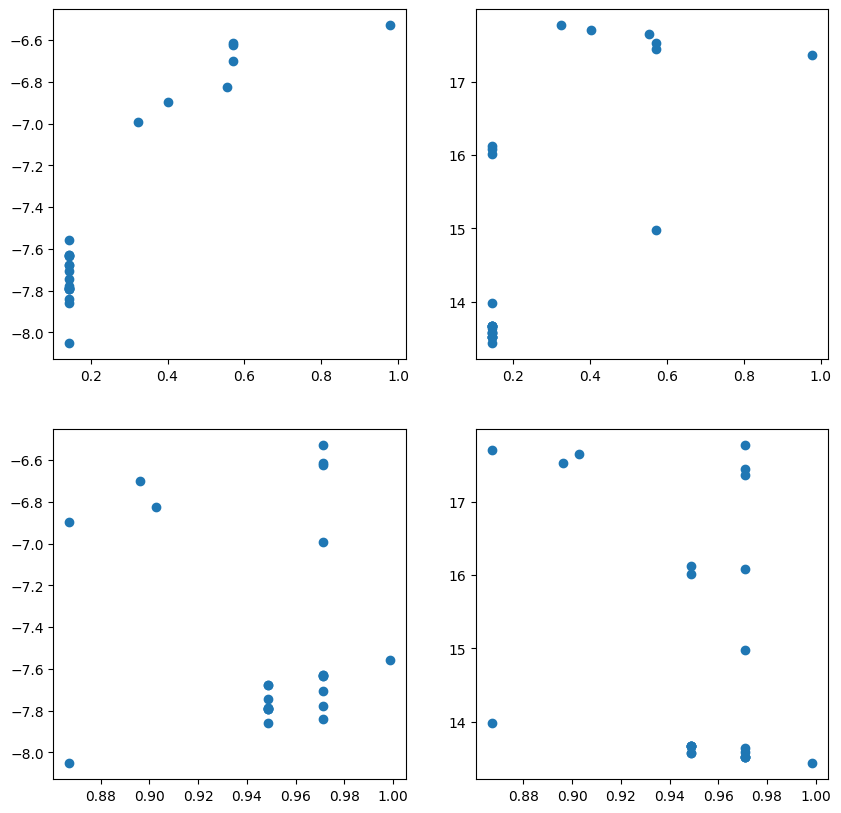

In [31]:

# # Assuming all_parents is your data containing 'alpha', 'gamma', and 'mean_rewards'
all_parents=a3
x = np.array([individual['alpha'] for individual in all_parents])
y = np.array([individual['gamma'] for individual in all_parents])
z = np.array([individual['mean_rewards'] for individual in all_parents])
w = np.array([individual['mean_steps'] for individual in all_parents])

# Create a 3D plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(221)
# Plot the line
ax.scatter(x, z)  # You can customize the line style here if needed
ax2 = fig.add_subplot(222)
ax2.scatter(x,w)

ax3 = fig.add_subplot(223)
# Plot the line
ax3.scatter(y, z, marker='o')  # You can customize the line style here if needed
ax4 = fig.add_subplot(224)
ax4.scatter(y,w,marker='o')


# Set labels and title
# ax.set_xlabel('Alpha')
# ax.set_ylabel('Gamma')
# ax.set_zlabel('Mean Rewards')
# ax.set_title('3D Plot of Mean Rewards')

# Show plot
plt.show()


In [ ]:
pt.plot()

In [12]:
def write_results_to_file(file_path, algorithm_results, algorithm_name):
    with open(file_path, 'a') as file:
        file.write(f"{algorithm_name} Results:\n")
        file.write("Best Hyperparameters:\n")
        file.write(str(algorithm_results[0]) + '\n')
        file.write(f"Best Mean Rewards: {algorithm_results[1]}\n")
        file.write(f"Best Mean Steps: {algorithm_results[2]}\n\n")

file_path = "results.txt"


In [11]:
episodes=5000

In [14]:

# Assuming genetic_algorithm returns (best_hyperparameters, best_mean_rewards, best_mean_steps, all_parents)
best_hyperparameters, best_mean_rewards, best_mean_steps, a1 = genetic_algorithm(env1, sarsa_s, e_s=1)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "SARSA_Softmax_e1")

best_hyperparameters, best_mean_rewards, best_mean_steps, a2 = genetic_algorithm(env1, qlearning_s, e_s=1)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "Q-Learning_Softmax_e1")



Generation 1
Experiment: 1


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:06<00:00, 806.12it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 813.68it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 822.88it/s] 


17.880933333333335
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 681.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 660.23it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 588.71it/s]


23.106333333333332
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1174.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 779.02it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 789.71it/s]


16.571066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1199.81it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1198.86it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1226.70it/s]


12.950866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 330.86it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:19<00:00, 255.03it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:32<00:00, 152.71it/s]


49.791666666666664
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 239.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:20<00:00, 242.95it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:18<00:00, 273.38it/s]


28.691
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 382.94it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 384.09it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 381.78it/s]


17.936733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 522.57it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 525.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 399.72it/s]


15.457
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 413.79it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 583.29it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 835.88it/s]


15.094733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 779.92it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 876.02it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 574.41it/s]


14.836533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 375.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:16<00:00, 299.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:23<00:00, 214.40it/s]


30.898066666666665
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 287.85it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:20<00:00, 239.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:25<00:00, 195.04it/s]


42.34373333333333
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 429.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 625.43it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 568.16it/s]


14.364533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 419.34it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 455.18it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 471.53it/s]


17.575266666666668
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 305.38it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 320.41it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:15<00:00, 314.35it/s]


28.322266666666668
Experiment: 1


100%|██████████| 5000/5000 [00:26<00:00, 189.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:25<00:00, 192.35it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:26<00:00, 188.77it/s]


51.095333333333336
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 362.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 394.94it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 398.78it/s]


21.439
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 275.35it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:22<00:00, 217.58it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:15<00:00, 316.73it/s]


33.06946666666666
Experiment: 1


100%|██████████| 5000/5000 [00:24<00:00, 204.09it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:23<00:00, 209.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:26<00:00, 191.15it/s]


63.968666666666664
Experiment: 1


100%|██████████| 5000/5000 [00:27<00:00, 180.42it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:19<00:00, 253.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:19<00:00, 259.35it/s]


59.595733333333335
[{'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.0831333333333335, 'mean_steps': 12.950866666666666}, {'alpha': 0.9964087587217001, 'gamma': 0.9717081331782426, 'epsilon_tau': 0.8282632033161708, 'mean_rewards': -6.843466666666667, 'mean_steps': 14.364533333333334}, {'alpha': 0.23308146470818797, 'gamma': 0.983987112463946, 'epsilon_tau': 0.6471353849706393, 'mean_rewards': -7.373133333333333, 'mean_steps': 14.836533333333334}, {'alpha': 0.5875695734075991, 'gamma': 0.9161566459246131, 'epsilon_tau': 0.4922154839610368, 'mean_rewards': -7.605266666666666, 'mean_steps': 15.094733333333334}, {'alpha': 0.9873901804429147, 'gamma': 0.9438783660635377, 'epsilon_tau': 0.9005047712561307, 'mean_rewards': -7.325266666666667, 'mean_steps': 15.457}, {'alpha': 0.2913438128718205, 'gamma': 0.9367698654828072, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.4498, 'mean_steps': 16.571066666666667}]
{'alpha': 0.

100%|██████████| 5000/5000 [00:04<00:00, 1187.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1167.27it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1168.80it/s]


12.971333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 805.87it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 830.46it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:03<00:00, 1255.02it/s]


15.796333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1153.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1190.32it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 791.79it/s]


14.9446
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 816.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 882.10it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 750.86it/s]


18.396066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 992.17it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 820.41it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1041.92it/s]


15.701333333333332
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1164.73it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1110.34it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1158.62it/s]


13.616533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 768.97it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 849.72it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 738.20it/s]


18.639133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 991.63it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1163.60it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 788.91it/s]


14.889466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1223.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 923.97it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 905.14it/s] 


14.8644
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 890.43it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 771.57it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 867.91it/s] 


17.403266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 923.11it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 960.75it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 784.27it/s]


16.037666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 656.22it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 638.75it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 668.41it/s]


22.446933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1069.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1061.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1060.78it/s]


13.869333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 758.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1222.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 798.00it/s]


16.378733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 777.86it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 793.91it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 800.95it/s] 


18.1792
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1164.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 807.74it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1004.23it/s]


14.506
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 733.70it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 717.58it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 651.88it/s]


20.0984
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 705.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 802.64it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1193.57it/s]


16.657133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1208.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1189.88it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1192.05it/s]


12.940466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1107.18it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1132.46it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1170.91it/s]


13.604866666666666
[{'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.084666666666666, 'mean_steps': 12.940466666666667}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.114066666666666, 'mean_steps': 12.971333333333334}, {'alpha': 0.2913438128718205, 'gamma': 0.9367698654828072, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.7268, 'mean_steps': 13.604866666666666}, {'alpha': 0.2913438128718205, 'gamma': 0.9367698654828072, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.743600000000001, 'mean_steps': 13.616533333333333}, {'alpha': 0.6052948090235989, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -6.983866666666667, 'mean_steps': 14.506}, {'alpha': 0.9873901804429147, 'gamma': 0.9438783660635377, 'epsilon_tau': 0.6471353849706393, 'mean_rewards': -6.8612, 'mean_steps': 14.8644}]
{'alpha': 0.2982076285058356, 'gamm

100%|██████████| 5000/5000 [00:04<00:00, 1225.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1195.01it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 773.84it/s]


14.5536
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1184.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1200.55it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1222.11it/s]


12.969333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1169.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1174.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 784.07it/s]


14.908266666666666
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 975.04it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1176.70it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1148.83it/s]


13.9702
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1031.49it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 818.31it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 798.05it/s]


16.1728
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 748.19it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1158.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 800.43it/s]


16.170066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 978.09it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 733.13it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 784.30it/s] 


17.126933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1058.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1152.72it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1105.74it/s]


12.989333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 217.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:22<00:00, 217.49it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:22<00:00, 219.06it/s]


75.61366666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 797.24it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1119.03it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 793.76it/s]


16.255533333333332
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1173.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1166.37it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 778.85it/s]


15.001
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 816.83it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 831.60it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1174.82it/s]


15.955266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1000.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 754.55it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1089.36it/s]


14.530133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1020.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1009.38it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1075.66it/s]


13.4946
Experiment: 1


100%|██████████| 5000/5000 [00:21<00:00, 229.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:20<00:00, 246.84it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:20<00:00, 244.73it/s]


65.6766
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 825.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 748.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 755.79it/s]


17.4662
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 867.54it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1060.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 973.62it/s] 


15.1108
Experiment: 1


100%|██████████| 5000/5000 [00:26<00:00, 188.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:27<00:00, 181.10it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:25<00:00, 192.76it/s]


84.90466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 709.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 726.28it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 682.67it/s]


20.9878
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1158.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1192.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1184.13it/s]


12.938066666666666
[{'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.0805333333333325, 'mean_steps': 12.938066666666666}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.117066666666666, 'mean_steps': 12.969333333333333}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.139, 'mean_steps': 12.989333333333333}, {'alpha': 0.2913438128718205, 'gamma': 0.9367698654828072, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.617999999999999, 'mean_steps': 13.4946}, {'alpha': 0.2913438128718205, 'gamma': 0.9367698654828072, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.449533333333334, 'mean_steps': 13.9702}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.0638, 'mean_steps': 14.5536}]
{'alpha': 0.2913438128718205, 'gamma': 0.9972

100%|██████████| 5000/5000 [00:04<00:00, 1177.26it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1192.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1201.37it/s]


12.9912
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1195.30it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1202.75it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1018.18it/s]


13.240866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1186.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1205.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1189.46it/s]


12.978266666666666
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 989.84it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 710.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1100.38it/s]


15.2582
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1002.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1013.10it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1076.23it/s]


13.469533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1047.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1126.66it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1187.76it/s]


12.9616
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 747.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1072.18it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1181.07it/s]


14.705066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1160.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1162.10it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1184.79it/s]


12.861
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1147.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1170.58it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 765.47it/s]


14.6316
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1220.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1242.79it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1200.64it/s]


12.441466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1171.49it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1198.77it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1174.50it/s]


12.9074
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1181.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 742.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1156.45it/s]


14.749133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1174.92it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 759.52it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1107.58it/s]


14.585266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1170.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 781.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1243.40it/s]


14.109666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1112.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1002.36it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 737.89it/s]


15.957066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 751.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1167.22it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1198.11it/s]


14.941733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 348.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 361.50it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 360.82it/s]


43.167
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 776.86it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1091.95it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 767.17it/s]


16.196133333333332
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 799.12it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 781.47it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 844.06it/s]


17.382666666666665
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 918.22it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 778.44it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1016.98it/s]


14.733066666666666
[{'alpha': 0.7344477622511424, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -6.561333333333334, 'mean_steps': 12.441466666666667}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -6.992666666666666, 'mean_steps': 12.861}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.0502666666666665, 'mean_steps': 12.9074}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.102533333333334, 'mean_steps': 12.9616}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.117666666666666, 'mean_steps': 12.978266666666666}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.128933333333333, 'mean_steps': 12.9912}]
{'alpha': 0.7344477622511424, 'gam

100%|██████████| 5000/5000 [00:04<00:00, 1006.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 783.35it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 793.74it/s]


16.116333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 776.76it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 783.93it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1179.82it/s]


16.215933333333332
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1146.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1186.99it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1176.42it/s]


12.935333333333332
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 788.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 808.52it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1192.45it/s]


16.205333333333332
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1207.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1010.93it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 803.45it/s]


14.862133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1194.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1202.60it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1199.55it/s]


12.9908
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1203.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1197.09it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1208.74it/s]


12.960933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1213.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1229.62it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1210.63it/s]


12.867066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:03<00:00, 1251.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1173.18it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1196.56it/s]


12.511533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1140.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1124.28it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1173.66it/s]


12.972933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1157.53it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1013.46it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 870.37it/s] 


15.024066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1248.65it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:03<00:00, 1268.14it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:03<00:00, 1275.17it/s]


12.4908
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 744.92it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 779.48it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 779.83it/s]


20.089266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1173.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1173.18it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1206.06it/s]


12.944866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 856.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 798.16it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 810.18it/s]


17.384933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1201.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 803.69it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1187.30it/s]


14.6448
Experiment: 1


100%|██████████| 5000/5000 [00:24<00:00, 204.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:24<00:00, 204.57it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:25<00:00, 198.63it/s]


79.69966666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 707.40it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 701.73it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 690.08it/s]


21.131933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1020.97it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1226.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 862.10it/s]


14.445066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1109.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1021.32it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1121.76it/s]


14.462133333333334
[{'alpha': 0.7344477622511424, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -6.622733333333334, 'mean_steps': 12.4908}, {'alpha': 0.7344477622511424, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -6.644933333333333, 'mean_steps': 12.511533333333333}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.001266666666667, 'mean_steps': 12.867066666666666}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.0813999999999995, 'mean_steps': 12.935333333333332}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5653609442362622, 'mean_rewards': -7.0944, 'mean_steps': 12.944866666666666}, {'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.1084, 'mean_steps': 12.960933333333333}]
{'alpha': 0.7344477622

100%|██████████| 5000/5000 [00:03<00:00, 1269.30it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 808.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 777.75it/s]


15.767933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 981.66it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1009.24it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1205.81it/s]


13.130866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1150.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 776.15it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1147.96it/s]


14.548333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 960.06it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1173.20it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1147.67it/s]


13.259
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1174.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 964.48it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1138.38it/s]


13.329
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1158.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1140.90it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 779.59it/s]


14.549533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 775.22it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1148.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1119.79it/s]


14.588133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1156.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1144.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1161.21it/s]


12.994066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1010.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1025.32it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 789.16it/s]


15.095466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 836.08it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1008.19it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1027.21it/s]


14.828866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 767.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1165.41it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1130.14it/s]


14.579266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1184.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1226.04it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 790.63it/s]


14.1492
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 969.85it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 963.33it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1156.34it/s]


13.700266666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1007.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 676.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 860.43it/s]


15.162933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1047.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 677.36it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1033.78it/s]


14.7136
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 687.47it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 744.15it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1210.78it/s]


15.787466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1108.76it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1116.38it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1166.59it/s]


12.957866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1160.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 772.75it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1185.32it/s]


14.5658
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 977.48it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 800.04it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1192.97it/s]


14.439266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1158.38it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 755.43it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1124.79it/s]


14.584333333333333
[{'alpha': 0.2982076285058356, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.101999999999999, 'mean_steps': 12.957866666666666}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5653609442362622, 'mean_rewards': -7.146, 'mean_steps': 12.994066666666667}, {'alpha': 0.7344477622511424, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -7.258266666666667, 'mean_steps': 13.130866666666666}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -7.396066666666667, 'mean_steps': 13.259}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5653609442362622, 'mean_rewards': -7.473733333333333, 'mean_steps': 13.329}, {'alpha': 0.7344477622511424, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -6.908266666666666, 'mean_steps': 14.439266666666667}]
{'alpha': 0.29820762850583

100%|██████████| 5000/5000 [00:04<00:00, 1021.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1031.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 694.16it/s]


14.607133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1084.86it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1154.77it/s]


12.991266666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 795.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 784.23it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 840.13it/s]


17.405533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 772.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1125.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 776.34it/s]


16.2276
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1104.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 715.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1098.65it/s]


14.558466666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 742.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 946.98it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 767.67it/s]


16.095933333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 732.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1074.68it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1140.77it/s]


14.602333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 863.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1107.38it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1034.88it/s]


13.304533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1189.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 719.24it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 741.74it/s]


15.754466666666668
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1020.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1011.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1009.76it/s]


14.003333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 382.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 361.66it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:13<00:00, 367.76it/s]


38.47306666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 727.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1170.51it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 952.38it/s] 


14.7968
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1117.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1094.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1096.02it/s]


12.9868
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1162.35it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 713.51it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1103.12it/s]


14.131933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 724.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 893.28it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 750.71it/s]


16.121866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:25<00:00, 199.77it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:25<00:00, 199.37it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:25<00:00, 193.05it/s]


74.45886666666667
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 610.57it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 628.46it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 650.22it/s]


21.558066666666665
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1123.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 885.33it/s] 


14.221
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 741.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 783.86it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1209.15it/s]


15.766333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 932.41it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 737.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1169.24it/s]


14.513866666666667
[{'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5445734654820482, 'mean_rewards': -7.130133333333333, 'mean_steps': 12.9868}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5653609442362622, 'mean_rewards': -7.133333333333333, 'mean_steps': 12.991266666666666}, {'alpha': 0.7344477622511424, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5810555639351482, 'mean_rewards': -6.6116, 'mean_steps': 14.131933333333333}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5653609442362622, 'mean_rewards': -7.4416, 'mean_steps': 13.304533333333334}, {'alpha': 0.6221665944445183, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5098555578834527, 'mean_rewards': -6.997199999999999, 'mean_steps': 14.513866666666667}, {'alpha': 0.2913438128718205, 'gamma': 0.9972476166484423, 'epsilon_tau': 0.5653609442362622, 'mean_rewards': -7.0676, 'mean_steps': 14.558466666666666}]
{'alpha': 0.2913438128718205, 'gam

100%|██████████| 5000/5000 [00:14<00:00, 337.30it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 331.85it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:14<00:00, 340.52it/s]


42.3648
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 580.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 692.12it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 718.15it/s]


18.666666666666668
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 543.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 544.56it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 531.59it/s]


23.332733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 535.70it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 555.64it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 638.86it/s]


23.8528
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 426.29it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 447.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 459.84it/s]


29.904533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 440.40it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 443.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 457.80it/s]


31.177533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 602.15it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 572.14it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 608.91it/s]


23.894066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 378.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 363.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 399.53it/s]


34.5244
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 673.83it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 680.25it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 677.88it/s]


18.7466
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 318.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 319.57it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:14<00:00, 341.59it/s]


42.781666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 382.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 378.72it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 387.94it/s]


37.1468
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 327.11it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 321.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:14<00:00, 341.61it/s]


43.2174
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 601.38it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 630.20it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 532.70it/s]


23.022066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 447.56it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 440.61it/s]


33.35106666666667
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 539.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 539.09it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 544.41it/s]


26.9086
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 431.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 467.41it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 466.87it/s]


31.7176
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 303.73it/s]


Experiment: 2


100%|██████████| 5000/5000 [24:03<00:00,  3.46it/s]  


Experiment: 3


100%|██████████| 5000/5000 [00:18<00:00, 273.55it/s]


50.59213333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 768.12it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 732.01it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 737.18it/s]


17.587933333333332
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 443.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 401.35it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 452.78it/s]


33.2534
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 353.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:14<00:00, 333.34it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:14<00:00, 351.61it/s]


42.343333333333334
[{'alpha': 0.7537599830444935, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -7.101466666666667, 'mean_steps': 17.587933333333332}, {'alpha': 0.7728707008613682, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.8808536994424401, 'mean_rewards': -7.9334, 'mean_steps': 18.7466}, {'alpha': 0.47148745492428, 'gamma': 0.9532164844839686, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -9.9174, 'mean_steps': 18.666666666666668}, {'alpha': 0.7769458959110571, 'gamma': 0.901026742392629, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -12.5002, 'mean_steps': 23.332733333333334}, {'alpha': 0.9110862261894498, 'gamma': 0.9139302721806695, 'epsilon_tau': 0.6480981955379908, 'mean_rewards': -14.0722, 'mean_steps': 23.022066666666667}, {'alpha': 0.8559242435370332, 'gamma': 0.9264889652043524, 'epsilon_tau': 0.8043520873114587, 'mean_rewards': -15.351333333333335, 'mean_steps': 23.8528}]
{'alpha': 0.7537599830444935, 'gamma': 0.978040331614624

100%|██████████| 5000/5000 [00:06<00:00, 749.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 916.68it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 753.21it/s]


16.785333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 711.94it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 976.93it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1028.24it/s]


16.0536
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 827.09it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 651.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 690.65it/s]


19.230266666666665
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 770.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 593.01it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 599.57it/s]


21.579066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 548.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 666.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 550.68it/s]


23.312466666666666
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 439.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 597.38it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 583.72it/s]


24.825866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 666.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1069.49it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 738.17it/s]


16.697333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 598.67it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 513.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 579.49it/s]


23.804733333333335
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 442.83it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 571.77it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 567.18it/s]


26.630866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 467.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 433.66it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 443.19it/s]


31.520133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 636.94it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 523.29it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 521.24it/s]


22.977866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 299.49it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:16<00:00, 312.34it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:17<00:00, 287.44it/s]


47.885
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 691.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1076.59it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 703.94it/s]


15.874666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 382.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 372.85it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:17<00:00, 286.45it/s]


39.3372
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 547.42it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 520.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 583.28it/s]


24.044066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 647.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 632.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 676.24it/s]


20.031533333333332
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 539.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 567.75it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 563.85it/s]


22.834666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 807.29it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 799.45it/s]


17.273266666666668
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 574.94it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 505.80it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 609.35it/s]


23.3718
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 731.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 597.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 729.10it/s]


18.952666666666666
[{'alpha': 0.7769458959110571, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.6930000000000005, 'mean_steps': 15.874666666666666}, {'alpha': 0.7537599830444935, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -6.889600000000001, 'mean_steps': 16.785333333333334}, {'alpha': 0.8559242435370332, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -7.6495999999999995, 'mean_steps': 16.697333333333333}, {'alpha': 0.7728707008613682, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.8808536994424401, 'mean_rewards': -8.5386, 'mean_steps': 16.0536}, {'alpha': 0.9110862261894498, 'gamma': 0.9532164844839686, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -8.461133333333333, 'mean_steps': 17.273266666666668}, {'alpha': 0.47148745492428, 'gamma': 0.9532164844839686, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -10.036266666666666, 'mean_steps': 19.230266666666665}]
{'alpha': 0

100%|██████████| 5000/5000 [00:06<00:00, 742.80it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 702.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 787.67it/s]


17.499266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 693.57it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 712.81it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1012.98it/s]


16.48293333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 710.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 753.02it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 678.66it/s]


18.081
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 835.01it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 717.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 881.79it/s] 


16.7676
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 674.60it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 665.30it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 808.61it/s]


18.655533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 742.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 763.87it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 598.49it/s]


19.170133333333332
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 609.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 661.47it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 579.58it/s]


21.5698
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 701.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 708.35it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 702.86it/s]


17.573333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 679.99it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 658.08it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1041.50it/s]


16.626333333333335
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 576.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 583.87it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 591.70it/s]


21.532933333333332
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 595.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 581.00it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 598.29it/s]


22.376466666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 822.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 615.80it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 617.15it/s]


18.860866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 718.13it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 794.81it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 789.21it/s]


17.8316
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 243.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:18<00:00, 276.69it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:20<00:00, 239.67it/s]


58.86813333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1128.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 754.23it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 773.95it/s]


16.137
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 748.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 751.56it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1062.03it/s]


16.267266666666668
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 760.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 727.41it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 763.12it/s]


17.6644
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 823.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 654.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 687.26it/s]


19.172866666666668
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 735.92it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 747.29it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 782.86it/s]


18.058333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 723.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 713.15it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 754.31it/s]


18.215666666666667
[{'alpha': 0.8099011676891458, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -6.9598, 'mean_steps': 16.137}, {'alpha': 0.7728707008613682, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -7.093066666666666, 'mean_steps': 16.267266666666668}, {'alpha': 0.7537599830444935, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -7.303933333333333, 'mean_steps': 16.48293333333333}, {'alpha': 0.7728707008613682, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -7.448533333333333, 'mean_steps': 16.626333333333335}, {'alpha': 0.7769458959110571, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.669999999999999, 'mean_steps': 17.499266666666667}, {'alpha': 0.8105544671239991, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -6.738933333333333, 'mean_steps': 17.573333333333334}]
{'alpha': 0.80

100%|██████████| 5000/5000 [00:06<00:00, 750.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 950.10it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 713.89it/s]


17.0096
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 768.03it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 856.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 785.12it/s]


15.819866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 758.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 753.50it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 734.50it/s]


17.911
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 724.11it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 799.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 704.03it/s]


17.888733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1131.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 752.18it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 744.54it/s]


15.709333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 744.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 735.30it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 861.87it/s]


16.834866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 705.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 886.12it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 713.71it/s]


17.0422
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 691.92it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 735.19it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 698.55it/s]


18.363466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 737.12it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1083.32it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 783.14it/s]


15.821666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 711.87it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 731.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 736.75it/s]


17.780733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 746.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 694.76it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 682.26it/s]


20.250333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 754.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 671.03it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 756.59it/s]


18.2088
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 759.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1124.90it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 758.54it/s]


15.865133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 492.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 522.22it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 521.03it/s]


27.112666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 699.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 754.94it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 733.19it/s]


17.499
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 661.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 852.13it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 609.12it/s]


18.858933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 740.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 974.85it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1055.72it/s]


15.240333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 715.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 744.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1061.28it/s]


15.925466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 690.76it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 744.49it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 720.51it/s]


17.814933333333332
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 744.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 690.66it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 718.28it/s]


18.921733333333332
[{'alpha': 0.8105544671239991, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -6.640666666666665, 'mean_steps': 15.821666666666667}, {'alpha': 0.7769458959110571, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.811533333333333, 'mean_steps': 15.709333333333333}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.680666666666666, 'mean_steps': 15.865133333333333}, {'alpha': 0.7728707008613682, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -6.7506666666666675, 'mean_steps': 15.925466666666667}, {'alpha': 0.8099011676891458, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -7.705066666666667, 'mean_steps': 15.240333333333334}, {'alpha': 0.7728707008613682, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -7.178866666666667, 'mean_steps': 15.8198666

100%|██████████| 5000/5000 [00:04<00:00, 1117.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1094.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1159.68it/s]


12.513333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 713.84it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 724.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 773.71it/s]


17.482066666666668
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 726.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 738.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 943.64it/s] 


16.503
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 706.49it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 734.88it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 812.31it/s]


17.042733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 703.83it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 722.12it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 727.81it/s]


17.9122
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 725.57it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 733.97it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 743.66it/s]


17.640133333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 750.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 825.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 778.94it/s]


17.5236
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 771.96it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 737.47it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 730.71it/s]


17.813133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 729.35it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 795.19it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 945.74it/s] 


16.329666666666668
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 722.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 931.97it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 724.74it/s]


16.828
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 768.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 770.37it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 755.31it/s]


17.5064
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 730.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 707.69it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1133.10it/s]


16.656466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 763.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 711.86it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 786.87it/s]


17.217
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 786.59it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 784.46it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 790.99it/s]


17.4972
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 375.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 377.60it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 384.68it/s]


39.403333333333336
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 783.93it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 743.87it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 819.22it/s]


17.757866666666665
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 760.77it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 740.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 741.53it/s]


17.869866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1167.47it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 763.36it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 821.92it/s]


15.942333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 730.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 737.07it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 739.70it/s]


18.257533333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 798.81it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 769.43it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 772.13it/s]


17.5034
[{'alpha': 0.8105544671239991, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6253866865823308, 'mean_rewards': -6.645, 'mean_steps': 12.513333333333334}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.763400000000001, 'mean_steps': 15.942333333333334}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.6593333333333335, 'mean_steps': 16.503}, {'alpha': 0.7728707008613682, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -7.0228, 'mean_steps': 17.042733333333334}, {'alpha': 0.7728707008613682, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -7.479866666666667, 'mean_steps': 16.656466666666667}, {'alpha': 0.8099011676891458, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.61134864426139, 'mean_rewards': -6.665333333333333, 'mean_steps': 17.4972}]
{'alpha': 0.8105544671239991, 'gamma': 0.9989328

100%|██████████| 5000/5000 [00:04<00:00, 1154.15it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 757.03it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 681.72it/s]


16.753933333333332
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1061.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 787.60it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 793.63it/s]


16.094266666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 763.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 737.69it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 760.92it/s]


17.5674
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 789.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 784.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 788.66it/s]


17.587333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1041.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 839.62it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 748.80it/s]


15.880133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 819.96it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 758.20it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 699.09it/s]


17.4668
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 652.46it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 664.34it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 648.21it/s]


21.228
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 737.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 811.99it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 777.81it/s]


17.6454
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 837.08it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 774.81it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 764.68it/s]


17.5598
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 757.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1085.76it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1135.96it/s]


15.039466666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 642.38it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 836.57it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 650.14it/s]


20.604533333333332
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 791.84it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1244.96it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 800.79it/s]


15.9528
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 751.77it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 739.32it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 742.33it/s]


17.509266666666665
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 730.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1006.54it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 915.20it/s] 


16.2358
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 848.08it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 789.16it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 807.44it/s]


17.5204
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 784.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 754.74it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 979.95it/s] 


16.9882
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 683.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 808.03it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 738.42it/s]


18.504
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.45it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 539.98it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 425.10it/s]


33.53
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 793.45it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 806.59it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 862.21it/s]


17.924866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 723.59it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 705.95it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 744.17it/s]


19.635466666666666
[{'alpha': 0.8105544671239991, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.7392867427673921, 'mean_rewards': -7.504200000000001, 'mean_steps': 15.039466666666666}, {'alpha': 0.7661298870806721, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -6.780799999999999, 'mean_steps': 15.9528}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.912, 'mean_steps': 16.094266666666666}, {'alpha': 0.7728707008613682, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -7.2312, 'mean_steps': 15.880133333333333}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -7.745533333333333, 'mean_steps': 16.2358}, {'alpha': 0.8099011676891458, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.61134864426139, 'mean_rewards': -6.6442000000000005, 'mean_steps': 17.4668}]
{'alpha': 0.8105544671239991, 'gamma': 0.998932

100%|██████████| 5000/5000 [00:06<00:00, 797.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 771.62it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 723.64it/s]


17.672133333333335
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1134.06it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 767.57it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 841.67it/s] 


15.634066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 756.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 738.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 745.36it/s]


17.5028
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 727.03it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 753.56it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 755.22it/s]


18.293466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 817.81it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 729.84it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 746.27it/s]


17.615933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 755.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 760.09it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 771.48it/s]


17.493133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 774.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1138.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 727.96it/s]


16.7442
Experiment: 1


100%|██████████| 5000/5000 [00:23<00:00, 212.87it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:23<00:00, 215.35it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:23<00:00, 210.31it/s]


72.79086666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 775.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 751.88it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 645.71it/s]


19.3038
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 640.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 658.23it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 665.23it/s]


22.985866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 784.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 780.15it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 792.59it/s]


17.562266666666666
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 472.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 499.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 502.13it/s]


31.0698
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 776.12it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 780.02it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 780.41it/s]


17.497733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 780.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 770.43it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 845.32it/s]


17.452266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 789.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 782.53it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 791.98it/s]


17.4736
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 793.61it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 785.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 783.15it/s]


17.5166
Experiment: 1


100%|██████████| 5000/5000 [00:20<00:00, 241.34it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:21<00:00, 232.54it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:21<00:00, 234.79it/s]


65.00033333333333
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 219.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:23<00:00, 214.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:22<00:00, 225.91it/s]


68.17213333333333
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 467.26it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 472.00it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 426.84it/s]


32.501133333333335
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 577.15it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 661.87it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 638.19it/s]


22.8204
[{'alpha': 0.7661298870806721, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.6677505247158421, 'mean_rewards': -6.7756, 'mean_steps': 15.634066666666667}, {'alpha': 0.7728707008613682, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.6202, 'mean_steps': 17.452266666666667}, {'alpha': 0.8105544671239991, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5145631441782427, 'mean_rewards': -6.6651333333333325, 'mean_steps': 17.497733333333333}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.676933333333333, 'mean_steps': 17.5028}, {'alpha': 0.8099011676891458, 'gamma': 0.9989328331025852, 'epsilon_tau': 0.61134864426139, 'mean_rewards': -6.691733333333333, 'mean_steps': 17.493133333333333}, {'alpha': 0.7304277805752963, 'gamma': 0.9780403316146244, 'epsilon_tau': 0.5015063240745913, 'mean_rewards': -6.688666666666666, 'mean_steps': 17.5166}]
{'alpha': 0.7661298870806721, 'gamma': 0.99893

100%|██████████| 5000/5000 [00:06<00:00, 819.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 829.96it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 812.53it/s]


17.526733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1174.34it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1086.90it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1069.71it/s]


13.3624
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 712.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 723.79it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 712.32it/s]


17.9616
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 608.67it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 590.88it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 589.14it/s]


23.3514
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 720.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 718.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 741.62it/s]


17.6776
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 724.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 759.37it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 749.87it/s]


18.4758
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 689.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 699.09it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 447.61it/s]


18.625333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:38<00:00, 130.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:34<00:00, 143.94it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:35<00:00, 139.45it/s]


84.01173333333334
Experiment: 1


100%|██████████| 5000/5000 [00:33<00:00, 150.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:32<00:00, 152.51it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:29<00:00, 167.65it/s]


78.6092
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 526.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 607.37it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 693.87it/s]


19.588933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 752.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 768.47it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 761.03it/s]


17.600933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 225.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:22<00:00, 218.90it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:28<00:00, 173.53it/s]


68.00113333333333
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 532.72it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 702.16it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 700.73it/s]


21.667066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 727.67it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 513.45it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:11<00:00, 452.97it/s]


17.7894
Experiment: 1


100%|██████████| 5000/5000 [00:35<00:00, 140.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:38<00:00, 129.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:33<00:00, 149.09it/s]


79.00446666666667
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 570.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 555.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 582.46it/s]


17.825066666666668
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 477.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 437.50it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 581.25it/s]


20.448666666666668
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 549.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 846.31it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 594.27it/s]


16.152666666666665
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 709.80it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 565.98it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 694.77it/s]


17.843666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 657.61it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 648.45it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 655.40it/s]


17.465133333333334
[{'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.4782, 'mean_steps': 13.3624}, {'alpha': 0.35561664332578513, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.2765308693802453, 'mean_rewards': -6.989533333333333, 'mean_steps': 16.152666666666665}, {'alpha': 0.524948663017214, 'gamma': 0.9747551094256376, 'epsilon_tau': 0.06967316375903877, 'mean_rewards': -6.6370000000000005, 'mean_steps': 17.465133333333334}, {'alpha': 0.48273012720647523, 'gamma': 0.9480366423702433, 'epsilon_tau': 0.17802997682625255, 'mean_rewards': -6.699800000000001, 'mean_steps': 17.526733333333333}, {'alpha': 0.4447098033965322, 'gamma': 0.8688296577166267, 'epsilon_tau': 0.0804855531755886, 'mean_rewards': -6.7708, 'mean_steps': 17.600933333333334}, {'alpha': 0.38663632036796736, 'gamma': 0.8639847159764125, 'epsilon_tau': 0.0709763542660838, 'mean_rewards': -6.847266666666667, 'mean_steps': 17.6776}]
{'alpha': 0.157414376048847

100%|██████████| 5000/5000 [00:05<00:00, 913.89it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 958.26it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 927.94it/s] 


13.3568
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 639.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 979.44it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1003.53it/s]


14.435133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 654.45it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 649.24it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 639.49it/s]


17.465133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 654.04it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 652.63it/s]


17.522333333333332
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 648.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 617.92it/s]


17.627133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 622.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 614.89it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 627.75it/s]


17.682666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 630.61it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 664.99it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 646.62it/s]


17.607333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 625.57it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 637.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 617.57it/s]


18.404
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 642.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 641.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 659.97it/s]


17.390466666666665
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1016.81it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 643.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 527.27it/s]


15.767866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 474.79it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 489.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:10<00:00, 497.92it/s]


22.8518
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 545.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 548.51it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 524.24it/s]


17.987733333333335
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 921.92it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 617.68it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 592.86it/s]


15.850866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 607.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 608.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:12<00:00, 402.78it/s]


17.373066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 491.09it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 576.30it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 581.56it/s]


17.509266666666665
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 554.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 577.88it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 575.37it/s]


17.358866666666668
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 534.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 422.80it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:09<00:00, 508.49it/s]


17.925733333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 793.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 818.80it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 792.15it/s]


17.550133333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 803.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 804.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 807.03it/s]


17.5636
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 767.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 766.71it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 763.61it/s]


18.6034
[{'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.4666, 'mean_steps': 13.3568}, {'alpha': 0.35561664332578513, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.2765308693802453, 'mean_rewards': -6.920533333333334, 'mean_steps': 14.435133333333333}, {'alpha': 0.6015484119981628, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.589133333333333, 'mean_steps': 15.767866666666666}, {'alpha': 0.48273012720647523, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.673733333333334, 'mean_steps': 15.850866666666667}, {'alpha': 0.9655392990838256, 'gamma': 0.9480366423702433, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.508466666666667, 'mean_steps': 17.358866666666668}, {'alpha': 0.8206798563047543, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.0709763542660838, 'mean_rewards': -6.517133333333334, 'mean_steps': 17.373066666666666}]
{'alpha': 0.1574

100%|██████████| 5000/5000 [00:04<00:00, 1157.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1148.69it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 777.16it/s]


14.981333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 800.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 807.14it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 808.65it/s]


17.766733333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 824.24it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 818.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 808.82it/s]


17.434666666666665
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 814.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 811.28it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1248.03it/s]


15.8596
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 821.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 881.37it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 885.25it/s]


17.3588
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 802.23it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 877.04it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 863.10it/s]


17.377866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 808.91it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 873.48it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 823.63it/s]


17.386333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 829.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 879.52it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 821.72it/s]


17.362866666666665
Experiment: 1


100%|██████████| 5000/5000 [00:03<00:00, 1259.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 825.03it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 815.42it/s]


15.840733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 828.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 815.53it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 826.06it/s]


17.433533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 816.80it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 770.17it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1203.72it/s]


15.916133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 823.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 869.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1027.57it/s]


16.016733333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 819.61it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 816.11it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 818.40it/s]


17.3572
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 800.73it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 806.54it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 800.08it/s]


17.6504
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1175.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1201.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1135.25it/s]


13.2896
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 825.56it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 831.76it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 817.61it/s]


17.496133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 830.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 822.29it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 834.26it/s]


17.355133333333335
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 737.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 732.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 570.19it/s]


22.064733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 778.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 791.72it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1186.42it/s]


16.770866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1229.60it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 811.51it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 820.51it/s]


16.019
[{'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.384399999999999, 'mean_steps': 13.2896}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.499933333333334, 'mean_steps': 14.981333333333334}, {'alpha': 0.48273012720647523, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.0709763542660838, 'mean_rewards': -6.6643333333333326, 'mean_steps': 15.840733333333333}, {'alpha': 0.48273012720647523, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.683466666666667, 'mean_steps': 15.8596}, {'alpha': 0.48273012720647523, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.734866666666666, 'mean_steps': 15.916133333333333}, {'alpha': 0.35561664332578513, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.8538, 'mean_steps': 16.019}]
{'alpha': 0.15741437604884775, 'gam

100%|██████████| 5000/5000 [00:06<00:00, 792.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1183.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1183.51it/s]


14.880933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1165.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1181.89it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 785.39it/s]


15.0178
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 820.99it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 810.76it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 809.78it/s]


17.501066666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 825.43it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:03<00:00, 1266.72it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 818.09it/s]


15.8578
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 829.85it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 818.30it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 810.26it/s]


17.548466666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 821.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1196.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 810.30it/s]


16.072733333333332
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 835.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 822.11it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 830.10it/s]


17.385
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 813.11it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 815.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 821.07it/s]


17.543733333333332
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 828.00it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 836.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 829.32it/s]


17.392333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 713.53it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 762.22it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 737.42it/s]


20.063866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 821.25it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 819.68it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1014.75it/s]


16.1986
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 761.71it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 771.22it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 660.43it/s]


17.65213333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 657.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 658.19it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 677.65it/s]


17.494066666666665
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 635.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 974.05it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 936.23it/s] 


14.9652
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 658.85it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 651.26it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 645.00it/s]


17.539
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 671.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 673.52it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1017.98it/s]


15.847466666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 660.66it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 654.01it/s]


17.33353333333333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 926.66it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1008.11it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 655.52it/s]


14.9974
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 675.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 689.84it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 679.68it/s]


17.35086666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 689.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 677.31it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 670.76it/s]


17.373733333333334
[{'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.378, 'mean_steps': 14.880933333333333}, {'alpha': 0.15741437604884775, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.451466666666666, 'mean_steps': 14.9652}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.506800000000001, 'mean_steps': 14.9974}, {'alpha': 0.48273012720647523, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.670866666666666, 'mean_steps': 15.847466666666667}, {'alpha': 0.48273012720647523, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -6.681866666666667, 'mean_steps': 15.8578}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.529133333333333, 'mean_steps': 15.0178}]
{'alpha': 0.15741437604884775, 'ga

100%|██████████| 5000/5000 [00:05<00:00, 908.10it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 976.47it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 993.41it/s] 


13.275666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 977.80it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 634.92it/s]


16.569066666666668
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 957.76it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 947.71it/s] 


Experiment: 3


100%|██████████| 5000/5000 [13:48<00:00,  6.03it/s]  


13.387333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 523.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 627.13it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 619.39it/s]


17.4964
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 718.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 728.62it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 747.84it/s]


17.505066666666668
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1088.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1050.30it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1053.92it/s]


13.366133333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 663.72it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 692.41it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 688.95it/s]


18.961266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 697.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 696.94it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 704.69it/s]


18.486466666666665
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 754.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 804.71it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 741.50it/s]


17.3772
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1010.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1028.73it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1037.48it/s]


13.528733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 711.13it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1032.48it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1073.11it/s]


14.963933333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1032.73it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1058.61it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1036.97it/s]


13.249866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1061.79it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1032.57it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1014.85it/s]


13.363866666666667
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 726.57it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 714.82it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1112.75it/s]


15.851266666666668
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 707.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 689.98it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 693.44it/s]


18.278266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1047.13it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1043.85it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1056.62it/s]


13.328333333333333
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 698.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1023.77it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 699.46it/s]


16.593
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.98it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1011.63it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 680.30it/s]


15.008866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1048.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1050.93it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1023.99it/s]


13.4324
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 729.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 693.49it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1049.17it/s]


15.8482
[{'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.359666666666667, 'mean_steps': 13.249866666666666}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.369600000000001, 'mean_steps': 13.275666666666666}, {'alpha': 0.15741437604884775, 'gamma': 0.9248929554629304, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.412733333333333, 'mean_steps': 13.328333333333333}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.4738, 'mean_steps': 13.366133333333334}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.4829333333333325, 'mean_steps': 13.363866666666667}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.14018102692739687, 'mean_rewards': -7.509666666666667, 'mean_steps': 13.387333333333334}]

100%|██████████| 5000/5000 [00:04<00:00, 1027.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1043.97it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1037.21it/s]


13.283533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1026.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1017.52it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1015.07it/s]


13.288266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 699.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 695.92it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1060.43it/s]


16.5938
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1028.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1034.29it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1045.42it/s]


13.396533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 693.00it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1027.15it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1059.06it/s]


14.969666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1039.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 677.05it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 899.01it/s] 


15.014533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 896.97it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 931.93it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 993.54it/s] 


13.297133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 999.53it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1007.71it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 694.70it/s]


15.0524
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1028.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1041.95it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1030.99it/s]


13.445666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 673.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 677.06it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 686.60it/s]


18.373666666666665
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1036.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1006.62it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1049.31it/s]


13.254933333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.99it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1009.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 977.43it/s] 


13.3796
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1010.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1028.39it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 704.12it/s]


14.959666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1022.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1002.13it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 971.17it/s] 


13.530666666666667
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 881.61it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 858.21it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 629.24it/s]


15.009533333333334
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1000.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1038.42it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1018.19it/s]


13.277066666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1021.26it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1018.91it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:04<00:00, 1022.57it/s]


13.404333333333334
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 678.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 675.16it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 984.44it/s] 


16.598666666666666
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1012.94it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 675.01it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 988.38it/s] 


14.904266666666667
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 889.49it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 985.63it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 930.17it/s] 


13.295933333333334
[{'alpha': 0.15741437604884775, 'gamma': 0.9811513093321904, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.349466666666667, 'mean_steps': 13.254933333333334}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.372533333333333, 'mean_steps': 13.277066666666666}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.3856, 'mean_steps': 13.283533333333333}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.387266666666666, 'mean_steps': 13.288266666666667}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.387266666666666, 'mean_steps': 13.295933333333334}, {'alpha': 0.15741437604884775, 'gamma': 0.9841607161287158, 'epsilon_tau': 0.02312229966738753, 'mean_rewards': -7.394000000000001, 'mean_steps': 13.2971333

100%|██████████| 5000/5000 [00:06<00:00, 810.97it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 865.32it/s] 


Experiment: 3


100%|██████████| 5000/5000 [4:38:59<00:00,  3.35s/it]   


14.915133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 898.89it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 962.19it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:07<00:00, 669.95it/s]


14.893733333333333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 959.53it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 608.83it/s]


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 996.32it/s] 


14.867133333333333
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1075.93it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 877.96it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:08<00:00, 592.06it/s]


14.884
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 898.12it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 984.39it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:05<00:00, 931.41it/s] 


13.286533333333333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 973.11it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 860.27it/s] 


Experiment: 3


100%|██████████| 5000/5000 [00:06<00:00, 830.82it/s]


13.281866666666666
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 933.56it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1055.97it/s]


Experiment: 3


  0%|          | 14/5000 [00:00<00:36, 136.34it/s]

: 

In [13]:

best_hyperparameters, best_mean_rewards, best_mean_steps, a3 = genetic_algorithm(env1, sarsa_e, e_s=0)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "SARSA_EpsilonGreedy_e1")

best_hyperparameters, best_mean_rewards, best_mean_steps, a4 = genetic_algorithm(env1, qlearning_e, e_s=0)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "Q-Learning_EpsilonGreedy_e1")



Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:29<00:00, 170.59it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:28<00:00, 175.99it/s]


77.6492
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 540.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 532.86it/s]


21.8727
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 675.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 630.47it/s]


17.7033
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 643.97it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 611.59it/s]


17.5236
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 720.22it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 525.97it/s]


16.9267
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 611.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 633.94it/s]


17.626
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 659.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 650.47it/s]


18.2483
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 629.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 975.45it/s] 


15.297
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 953.17it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 612.91it/s]


16.0176
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 615.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 557.77it/s]


18.2927
Experiment: 1


100%|██████████| 5000/5000 [00:29<00:00, 168.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:28<00:00, 175.85it/s]


80.646
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 615.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 611.90it/s]


18.202
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 633.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 691.21it/s]


17.3414
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 284.85it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 317.20it/s]


40.2355
Experiment: 1


100%|██████████| 5000/5000 [00:29<00:00, 167.85it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:28<00:00, 172.66it/s]


83.792
[{'alpha': 0.32382774928750035, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -6.967499999999999, 'mean_steps': 15.297}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.765000000000001, 'mean_steps': 16.0176}, {'alpha': 0.571453806135642, 'gamma': 0.8962393698881199, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.6873000000000005, 'mean_steps': 17.5236}, {'alpha': 0.5535111979457585, 'gamma': 0.9029062966585342, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -6.7937, 'mean_steps': 17.626}, {'alpha': 0.40113772522292, 'gamma': 0.8672173783032825, 'epsilon_tau': 0.08487826787820037, 'mean_rewards': -6.8749, 'mean_steps': 17.7033}]
{'alpha': 0.32382774928750035, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -6.967499999999999, 'mean_steps': 15.297}

Best Hyperparameters: {'alpha': 0.32382774928750035, 'gamma': 0.9710583279233082, 'epsilon

100%|██████████| 5000/5000 [00:07<00:00, 636.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 579.44it/s]


17.7754
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 785.97it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 824.43it/s] 


13.6445
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 640.63it/s]


17.5347
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 633.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 645.73it/s]


17.6568
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 629.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 639.22it/s]


17.7107
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1023.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 652.63it/s]


14.982
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 602.83it/s]


17.6464
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 794.07it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 777.06it/s]


13.7278
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 580.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 637.63it/s]


17.5453
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 643.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 627.04it/s]


17.7897
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 647.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 620.04it/s]


17.3366
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 573.87it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 572.00it/s]


17.3539
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 554.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 580.85it/s]


17.6849
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 777.47it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 715.28it/s] 


15.6699
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 640.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 616.54it/s]


17.7259
[{'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.761100000000001, 'mean_steps': 13.6445}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -7.84, 'mean_steps': 13.7278}, {'alpha': 0.571453806135642, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.6226, 'mean_steps': 14.982}, {'alpha': 0.144984004614485, 'gamma': 0.8672173783032825, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -8.127, 'mean_steps': 15.6699}, {'alpha': 0.9781375756121281, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -6.483700000000001, 'mean_steps': 17.3366}]
{'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.761100000000001, 'mean_steps': 13.6445}

Best Hyperparameters: {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.1740321

100%|██████████| 5000/5000 [00:05<00:00, 867.81it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 886.55it/s] 


13.5333
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 860.72it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 998.32it/s] 


13.734
Experiment: 1


100%|██████████| 5000/5000 [08:51<00:00,  9.40it/s]  


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 662.10it/s]


17.4529
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 901.85it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 872.28it/s] 


13.977
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.12it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 655.35it/s]


17.3678
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 647.35it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 640.75it/s]


17.6929
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.38it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 644.05it/s]


17.318
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 927.84it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 918.50it/s] 


13.6257
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 656.42it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 701.09it/s]


17.3513
Experiment: 1


100%|██████████| 5000/5000 [00:27<00:00, 179.96it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:27<00:00, 180.98it/s]


79.1952
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 653.58it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 647.53it/s]


17.634
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 898.36it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 908.71it/s] 


13.6868
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 968.13it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 653.27it/s]


14.9692
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 641.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 634.03it/s]


17.5654
Experiment: 1


100%|██████████| 5000/5000 [00:26<00:00, 190.99it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:26<00:00, 188.34it/s]


74.8467
[{'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.6579999999999995, 'mean_steps': 13.5333}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.7355, 'mean_steps': 13.6257}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -7.8206, 'mean_steps': 13.6868}, {'alpha': 0.571453806135642, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.6028, 'mean_steps': 14.9692}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -7.860200000000001, 'mean_steps': 13.734}]
{'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.6579999999999995, 'mean_steps': 13.5333}

Best Hyperparameters: {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.174

100%|██████████| 5000/5000 [00:05<00:00, 883.27it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 909.20it/s] 


13.6638
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 890.26it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 618.87it/s]


16.0199
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 921.24it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 618.67it/s]


16.0894
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 634.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 987.02it/s] 


14.9789
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 909.80it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 899.96it/s] 


13.6673
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 906.02it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 877.42it/s] 


13.6615
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 661.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 660.31it/s]


17.3837
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 679.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 992.48it/s] 


14.9645
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 870.79it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 914.29it/s] 


13.6909
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 923.86it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 909.10it/s] 


13.6251
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 907.56it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 919.34it/s] 


13.6467
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 886.80it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 921.08it/s] 


13.5914
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 576.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 577.52it/s]


18.3994
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 839.56it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 876.04it/s] 


13.6097
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 689.70it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 694.80it/s]


17.4907
[{'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.7005, 'mean_steps': 13.5914}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.7028, 'mean_steps': 13.6097}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -7.7741, 'mean_steps': 13.6251}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.7549, 'mean_steps': 13.6467}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -7.786899999999999, 'mean_steps': 13.6615}]
{'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.7005, 'mean_steps': 13.5914}

Best Hyperparameters: {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336}
Best Me

100%|██████████| 5000/5000 [00:05<00:00, 918.24it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 927.77it/s] 


13.5237
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 915.25it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 947.46it/s] 


13.5228
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 918.06it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 932.90it/s] 


13.6428
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 919.94it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 922.13it/s] 


13.5699
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 894.78it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 566.94it/s]


16.1265
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 796.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 800.57it/s]


13.7032
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 802.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 833.37it/s] 


13.6837
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 260.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:19<00:00, 256.54it/s]


52.3149
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 902.44it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 882.88it/s] 


13.5902
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 818.96it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 793.18it/s]


13.6291
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 551.59it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 885.38it/s]


14.9079
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 863.87it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 903.44it/s] 


13.6127
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 919.36it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 893.21it/s] 


13.6278
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 373.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 370.49it/s]


32.8839
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 816.80it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 826.10it/s]


13.43
[{'alpha': 0.144984004614485, 'gamma': 0.9986305913853659, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.5582, 'mean_steps': 13.43}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.6312999999999995, 'mean_steps': 13.5237}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.633, 'mean_steps': 13.5228}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.6794, 'mean_steps': 13.5699}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.7066, 'mean_steps': 13.5902}]
{'alpha': 0.144984004614485, 'gamma': 0.9986305913853659, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.5582, 'mean_steps': 13.43}

Best Hyperparameters: {'alpha': 0.144984004614485, 'gamma': 0.9986305913853659, 'epsilon_tau': 0.14211968508163336}
Best Mean Re

100%|██████████| 5000/5000 [00:07<00:00, 683.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 429.80it/s]


15.1654
Experiment: 1


100%|██████████| 5000/5000 [00:22<00:00, 224.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [01:34<00:00, 52.67it/s] 


44.815
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 259.84it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:18<00:00, 269.37it/s]


31.1971
Experiment: 1


100%|██████████| 5000/5000 [00:45<00:00, 110.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:45<00:00, 109.42it/s]


80.2771
Experiment: 1


100%|██████████| 5000/5000 [00:26<00:00, 188.41it/s]


Experiment: 2


100%|██████████| 5000/5000 [42:08<00:00,  1.98it/s]   


43.2222
Experiment: 1


100%|██████████| 5000/5000 [40:27<00:00,  2.06it/s]  


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 314.99it/s]


26.1059
Experiment: 1


100%|██████████| 5000/5000 [00:17<00:00, 292.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:16<00:00, 304.90it/s]


43.2847
Experiment: 1


100%|██████████| 5000/5000 [00:21<00:00, 231.77it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:20<00:00, 245.83it/s]


54.7771
Experiment: 1


100%|██████████| 5000/5000 [00:27<00:00, 184.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:27<00:00, 184.23it/s]


46.2317
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 366.89it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 361.39it/s]


22.4811
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 479.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 461.26it/s]


17.6239
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 663.46it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 425.58it/s]


15.323
Experiment: 1


100%|██████████| 5000/5000 [00:42<00:00, 118.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:43<00:00, 115.28it/s]


73.1318
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.15it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 434.39it/s]


17.6415
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 601.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 586.49it/s]


13.6211
[{'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.6843, 'mean_steps': 13.6211}, {'alpha': 0.418835814383991, 'gamma': 0.9641438467112834, 'epsilon_tau': 0.2330668964982972, 'mean_rewards': -6.8223, 'mean_steps': 15.1654}, {'alpha': 0.3093881911947178, 'gamma': 0.954546926814583, 'epsilon_tau': 0.23088512081143625, 'mean_rewards': -6.9754000000000005, 'mean_steps': 15.323}, {'alpha': 0.5875518438382984, 'gamma': 0.8691794013678705, 'epsilon_tau': 0.11459746954832613, 'mean_rewards': -6.7959, 'mean_steps': 17.6415}, {'alpha': 0.2537001837146524, 'gamma': 0.8597482143726983, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -10.312100000000001, 'mean_steps': 17.6239}]
{'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.6843, 'mean_steps': 13.6211}

Best Hyperparameters: {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.104634116189

100%|██████████| 5000/5000 [00:08<00:00, 584.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 587.97it/s]


13.6636
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 434.03it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 622.14it/s]


15.1333
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 421.29it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 642.92it/s]


15.3572
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 431.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 437.89it/s]


17.6454
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 443.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 445.44it/s]


18.1342
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 485.99it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 470.75it/s]


17.4267
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 423.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 635.16it/s]


15.545
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 442.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 423.53it/s]


17.82
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 350.67it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 376.38it/s]


20.0785
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 434.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 663.23it/s]


15.1617
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 392.30it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 409.63it/s]


18.9622
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 432.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 440.99it/s]


17.5067
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 452.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 402.42it/s]


17.6357
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 432.68it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 385.61it/s]


18.2499
Experiment: 1


100%|██████████| 5000/5000 [00:16<00:00, 301.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 373.44it/s]


24.4356
[{'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.7538, 'mean_steps': 13.6636}, {'alpha': 0.418835814383991, 'gamma': 0.9641438467112834, 'epsilon_tau': 0.2330668964982972, 'mean_rewards': -6.7826, 'mean_steps': 15.1333}, {'alpha': 0.418835814383991, 'gamma': 0.954546926814583, 'epsilon_tau': 0.2330668964982972, 'mean_rewards': -6.8056, 'mean_steps': 15.1617}, {'alpha': 0.3093881911947178, 'gamma': 0.954546926814583, 'epsilon_tau': 0.23088512081143625, 'mean_rewards': -7.0204, 'mean_steps': 15.3572}, {'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.2325, 'mean_steps': 15.545}]
{'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.7538, 'mean_steps': 13.6636}

Best Hyperparameters: {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405}
Best Mean Rewards: -

100%|██████████| 5000/5000 [00:07<00:00, 634.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 652.57it/s]


13.6538
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 456.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 454.08it/s]


17.622
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 678.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 452.71it/s]


15.1655
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 459.29it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 452.06it/s]


17.8157
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 640.99it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 661.67it/s]


13.0806
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 465.02it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 471.70it/s]


17.3942
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 456.18it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 739.90it/s]


14.967
Experiment: 1


100%|██████████| 5000/5000 [00:41<00:00, 119.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 623.60it/s]


15.3292
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 684.45it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 449.72it/s]


15.3767
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 639.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 425.54it/s]


16.1502
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 505.78it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 445.01it/s]


17.7135
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 613.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 617.79it/s]


13.7124
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 362.47it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 376.09it/s]


20.4171
Experiment: 1


100%|██████████| 5000/5000 [00:19<00:00, 261.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:14<00:00, 346.05it/s]


28.4219
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 655.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 444.66it/s]


15.1666
[{'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.189, 'mean_steps': 13.0806}, {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.7296, 'mean_steps': 13.6538}, {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.1909063538379053, 'mean_rewards': -7.8131, 'mean_steps': 13.7124}, {'alpha': 0.7702808201957486, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -6.6411, 'mean_steps': 14.967}, {'alpha': 0.418835814383991, 'gamma': 0.954546926814583, 'epsilon_tau': 0.2330668964982972, 'mean_rewards': -6.8085, 'mean_steps': 15.1655}]
{'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.189, 'mean_steps': 13.0806}

Best Hyperparameters: {'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536}
Best Mean Rewards: 

100%|██████████| 5000/5000 [00:07<00:00, 635.96it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 673.75it/s]


13.0689
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 574.82it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 361.38it/s]


16.0752
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 563.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 545.86it/s]


13.7478
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 401.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 447.96it/s]


17.4391
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 448.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 461.62it/s]


17.6217
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 451.60it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 464.36it/s]


17.348
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 368.65it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 382.68it/s]


21.4445
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 525.47it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 439.43it/s]


17.3977
Experiment: 1


100%|██████████| 5000/5000 [00:10<00:00, 472.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 412.27it/s]


17.474
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 428.42it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 415.42it/s]


17.374
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 417.80it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 446.81it/s]


17.5784
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 644.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 421.98it/s]


15.1551
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.76it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 615.97it/s]


15.547
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 438.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 418.61it/s]


17.4929
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 393.59it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 386.06it/s]


18.3813
[{'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.1907, 'mean_steps': 13.0689}, {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.1909063538379053, 'mean_rewards': -7.8445, 'mean_steps': 13.7478}, {'alpha': 0.418835814383991, 'gamma': 0.954546926814583, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -6.7966, 'mean_steps': 15.1551}, {'alpha': 0.2537001837146524, 'gamma': 0.9613861161075299, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.2258, 'mean_steps': 15.547}, {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.7641, 'mean_steps': 16.0752}]
{'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.1907, 'mean_steps': 13.0689}

Best Hyperparameters: {'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536}
Best Mean Reward

100%|██████████| 5000/5000 [00:12<00:00, 410.75it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 392.80it/s]


18.0536
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 597.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 424.64it/s]


16.2448
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 696.11it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 420.56it/s]


15.1332
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 416.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 378.41it/s]


17.9538
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 548.70it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 549.10it/s]


13.6684
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 605.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 564.04it/s]


13.089
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 357.52it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 362.48it/s]


20.6119
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 405.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 396.12it/s]


17.4091
Experiment: 1


100%|██████████| 5000/5000 [00:13<00:00, 372.65it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:12<00:00, 389.55it/s]


18.5609
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 437.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 462.48it/s]


17.4088
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 426.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 581.95it/s]


15.7854
Experiment: 1


100%|██████████| 5000/5000 [00:12<00:00, 394.83it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 597.43it/s]


15.2468
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 550.79it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 416.78it/s]


15.9475
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 709.97it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 442.96it/s]


14.9628
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 628.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 589.41it/s]

13.054
[{'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.1724, 'mean_steps': 13.054}, {'alpha': 0.2537001837146524, 'gamma': 0.9613861161075299, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.2123, 'mean_steps': 13.089}, {'alpha': 0.1438502987898517, 'gamma': 0.918524478157768, 'epsilon_tau': 0.10463411618927405, 'mean_rewards': -7.758, 'mean_steps': 13.6684}, {'alpha': 0.6085861551476669, 'gamma': 0.9613861161075299, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -6.6019000000000005, 'mean_steps': 14.9628}, {'alpha': 0.418835814383991, 'gamma': 0.954546926814583, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -6.7915, 'mean_steps': 15.1332}]
{'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536, 'mean_rewards': -7.1724, 'mean_steps': 13.054}

Best Hyperparameters: {'alpha': 0.2537001837146524, 'gamma': 0.9485776343872194, 'epsilon_tau': 0.28566164826011536}
Best M

In [15]:
best_hyperparameters, best_mean_rewards, best_mean_steps, b1 = genetic_algorithm(env2, sarsa_s, e_s=1)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "SARSA_Softmax_e2")



Generation 1
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 605.17it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 600.37it/s]


12.6893
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 578.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 569.26it/s]


12.346
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 592.34it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 607.82it/s]


12.3473
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 606.29it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 678.32it/s]


12.4177
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 347.86it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:15<00:00, 324.58it/s]


23.7215
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 584.16it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 649.69it/s]


12.4884
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 531.94it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 552.44it/s]


13.3922
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 595.04it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 541.08it/s]


12.6343
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 534.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 570.30it/s]


13.1543
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 546.51it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:09<00:00, 518.01it/s]


13.9737
Experiment: 1


100%|██████████| 5000/5000 [00:15<00:00, 328.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 361.60it/s]


24.1819
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 427.74it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:11<00:00, 450.92it/s]


19.3699
Experiment: 1


100%|██████████| 5000/5000 [00:11<00:00, 450.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 478.68it/s]


19.5768
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 676.28it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 660.21it/s]


12.4464
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 699.24it/s]


12.317
[{'alpha': 0.9856847745993726, 'gamma': 0.9988596854027793, 'epsilon_tau': 0.8992102247713383, 'mean_rewards': -1.475, 'mean_steps': 12.317}, {'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4992999999999999, 'mean_steps': 12.346}, {'alpha': 0.6859895669882135, 'gamma': 0.9362800404857237, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.5774, 'mean_steps': 12.4177}, {'alpha': 0.9123779569647033, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.5325262552487584, 'mean_rewards': -1.681, 'mean_steps': 12.3473}, {'alpha': 0.5871146823729269, 'gamma': 0.9556409942734947, 'epsilon_tau': 0.5258438316249212, 'mean_rewards': -1.6152000000000002, 'mean_steps': 12.4464}]
{'alpha': 0.9856847745993726, 'gamma': 0.9988596854027793, 'epsilon_tau': 0.8992102247713383, 'mean_rewards': -1.475, 'mean_steps': 12.317}

Best Hyperparameters: {'alpha': 0.9856847745993726, 'gamma': 0.9988596854027793, 'epsilon_tau': 0.8992102247713383

100%|██████████| 5000/5000 [00:07<00:00, 637.08it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 644.51it/s]


12.7731
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 662.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 648.94it/s]


12.3582
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 642.96it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 659.01it/s]


12.4263
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 667.34it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 662.98it/s]


12.3321
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 656.81it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 657.07it/s]


12.4531
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 593.20it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 568.33it/s]


13.5823
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 654.64it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 713.41it/s]


12.307
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 631.33it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 646.80it/s]


12.3707
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 633.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 690.27it/s]


12.5643
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 653.22it/s]


12.4009
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 656.87it/s]


12.4938
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 554.56it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 632.72it/s]


13.5614
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 641.72it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 691.16it/s]


12.4041
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 769.35it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 945.20it/s] 


13.3594
Experiment: 1


100%|██████████| 5000/5000 [01:14<00:00, 67.42it/s]  


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 607.53it/s]


12.4583
[{'alpha': 0.8199917205662351, 'gamma': 0.9842669081044668, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.4545, 'mean_steps': 12.307}, {'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5162, 'mean_steps': 12.3582}, {'alpha': 0.6509318848285874, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5316, 'mean_steps': 12.3707}, {'alpha': 0.6123544032718267, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.5598999999999998, 'mean_steps': 12.4009}, {'alpha': 0.6859895669882135, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.5627, 'mean_steps': 12.4041}]
{'alpha': 0.8199917205662351, 'gamma': 0.9842669081044668, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.4545, 'mean_steps': 12.307}

Best Hyperparameters: {'alpha': 0.8199917205662351, 'gamma': 0.9842669081044668, 'epsilon_tau': 0.45263363511766036}


100%|██████████| 5000/5000 [00:08<00:00, 610.95it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 628.18it/s]


12.3047
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 625.93it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 582.14it/s]


12.3517
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 650.71it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 612.92it/s]


12.4258
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 711.54it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 694.17it/s]


12.4536
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 686.05it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 763.03it/s]


12.425
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 724.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 706.74it/s]


12.3967
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 700.22it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 685.20it/s]


12.348
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 668.60it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 750.52it/s]


12.3829
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 673.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 693.84it/s]


12.3538
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 662.26it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 674.47it/s]


12.4374
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 695.37it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 687.17it/s]


12.4266
Experiment: 1


100%|██████████| 5000/5000 [00:06<00:00, 758.39it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:05<00:00, 875.87it/s] 


12.4604
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 974.07it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 721.32it/s]


12.4434
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 646.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 645.67it/s]


12.4642
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 634.44it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:06<00:00, 720.97it/s]


12.4662
[{'alpha': 0.8199917205662351, 'gamma': 0.9842669081044668, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.4521, 'mean_steps': 12.3047}, {'alpha': 0.7754895550330865, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5011, 'mean_steps': 12.348}, {'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5066, 'mean_steps': 12.3517}, {'alpha': 0.6859895669882135, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.509, 'mean_steps': 12.3538}, {'alpha': 0.6509318848285874, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5434999999999999, 'mean_steps': 12.3829}]
{'alpha': 0.8199917205662351, 'gamma': 0.9842669081044668, 'epsilon_tau': 0.45263363511766036, 'mean_rewards': -1.4521, 'mean_steps': 12.3047}

Best Hyperparameters: {'alpha': 0.8199917205662351, 'gamma': 0.9842669081044668, 'epsilon_tau': 0.45263363511766036}


100%|██████████| 5000/5000 [00:07<00:00, 650.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 658.65it/s]


12.3833
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 642.27it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 626.11it/s]


12.3205
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 650.87it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 697.52it/s]


12.2985
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 643.59it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 653.58it/s]


12.4187
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 622.63it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 677.81it/s]


12.4176
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 639.40it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 711.81it/s]


12.3203
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 643.86it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 651.52it/s]


12.4759
Experiment: 1


100%|██████████| 5000/5000 [00:24<00:00, 206.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:25<00:00, 196.57it/s]


45.9214
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 581.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 667.15it/s]


12.702
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 648.36it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 624.73it/s]


12.3857
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 635.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 594.01it/s]


12.3524
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 592.23it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 570.67it/s]


12.4125
Experiment: 1


100%|██████████| 5000/5000 [00:18<00:00, 268.18it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:19<00:00, 261.70it/s]


31.8921
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 601.88it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 589.14it/s]


12.3103
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 568.03it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 649.92it/s]


12.3886
[{'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4413, 'mean_steps': 12.2985}, {'alpha': 0.7891677587950872, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4604, 'mean_steps': 12.3103}, {'alpha': 0.8199917205662351, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4667, 'mean_steps': 12.3203}, {'alpha': 0.7754895550330865, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.471, 'mean_steps': 12.3205}, {'alpha': 0.6859895669882135, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5087, 'mean_steps': 12.3524}]
{'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4413, 'mean_steps': 12.2985}

Best Hyperparameters: {'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686}
Best Mean R

100%|██████████| 5000/5000 [00:08<00:00, 575.96it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 556.79it/s]


12.3581
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 529.08it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:10<00:00, 487.38it/s]


13.334
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 556.00it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 618.12it/s]


12.347
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 578.31it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 663.94it/s]


12.3769
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 628.55it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 650.32it/s]


12.3803
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 635.22it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 631.07it/s]


12.3135
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 631.19it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 623.67it/s]


12.3971
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 622.49it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 606.39it/s]


12.3701
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 661.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 610.07it/s]


12.4586
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 609.18it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 620.15it/s]


12.3192
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 637.45it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 628.20it/s]


12.3521
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 612.10it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 595.86it/s]


12.5417
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 607.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 609.07it/s]


12.3047
Experiment: 1


100%|██████████| 5000/5000 [00:14<00:00, 351.06it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:13<00:00, 358.50it/s]


23.2546
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 679.66it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 629.23it/s]


12.3412
[{'alpha': 0.8199917205662351, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4544000000000001, 'mean_steps': 12.3047}, {'alpha': 0.7605587519945768, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4603000000000002, 'mean_steps': 12.3135}, {'alpha': 0.9164190260064987, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4646, 'mean_steps': 12.3192}, {'alpha': 0.7891677587950872, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5089000000000001, 'mean_steps': 12.3521}, {'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.5149, 'mean_steps': 12.3581}]
{'alpha': 0.8199917205662351, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4544000000000001, 'mean_steps': 12.3047}

Best Hyperparameters: {'alpha': 0.8199917205662351, 'gamma': 0.9691010096348396

100%|██████████| 5000/5000 [00:07<00:00, 626.01it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 608.36it/s]


12.3431
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 610.90it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 603.10it/s]


12.3165
Experiment: 1


100%|██████████| 5000/5000 [00:07<00:00, 670.09it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 629.43it/s]


12.3368
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 621.50it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 620.80it/s]


12.3454
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 614.48it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 644.88it/s]


12.3207
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 608.67it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 583.02it/s]


13.0578
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 582.84it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 585.83it/s]


12.9569
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 594.69it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 606.21it/s]


12.3575
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 605.14it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 582.34it/s]


12.3389
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 585.62it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 626.08it/s]


12.3263
Experiment: 1


100%|██████████| 5000/5000 [00:08<00:00, 573.70it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:07<00:00, 629.02it/s]


12.4342
Experiment: 1


100%|██████████| 5000/5000 [00:09<00:00, 541.32it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:08<00:00, 578.48it/s]


12.9772
Experiment: 1


100%|██████████| 5000/5000 [00:36<00:00, 137.21it/s]


Experiment: 2


100%|██████████| 5000/5000 [2:17:55<00:00,  1.66s/it]      


66.8503
Experiment: 1


100%|██████████| 5000/5000 [00:05<00:00, 976.26it/s] 


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1013.06it/s]


12.3353
Experiment: 1


100%|██████████| 5000/5000 [00:04<00:00, 1087.30it/s]


Experiment: 2


100%|██████████| 5000/5000 [00:04<00:00, 1076.57it/s]

12.3098
[{'alpha': 0.9164190260064987, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4540000000000002, 'mean_steps': 12.3098}, {'alpha': 0.7605587519945768, 'gamma': 0.9691010096348396, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4651, 'mean_steps': 12.3165}, {'alpha': 0.7891677587950872, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4687999999999999, 'mean_steps': 12.3207}, {'alpha': 0.9164190260064987, 'gamma': 0.9156310637651728, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4830999999999999, 'mean_steps': 12.3353}, {'alpha': 0.9164190260064987, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.488, 'mean_steps': 12.3368}]
{'alpha': 0.9164190260064987, 'gamma': 0.9409643016845897, 'epsilon_tau': 0.31547948659180686, 'mean_rewards': -1.4540000000000002, 'mean_steps': 12.3098}

Best Hyperparameters: {'alpha': 0.9164190260064987, 'gamma': 0.9409643016845897,

In [18]:
print(a3)
[{'alpha': 0.32382774928750035, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -6.9919, 'mean_steps': 17.7754}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.790699999999999, 'mean_steps': 13.6638}, {'alpha': 0.571453806135642, 'gamma': 0.8962393698881199, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.699, 'mean_steps': 17.5347}, {'alpha': 0.5535111979457585, 'gamma': 0.9029062966585342, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -6.8264, 'mean_steps': 17.6568}, {'alpha': 0.40113772522292, 'gamma': 0.8672173783032825, 'epsilon_tau': 0.08487826787820037, 'mean_rewards': -6.8946000000000005, 'mean_steps': 17.7107}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.790699999999999, 'mean_steps': 13.6638}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -7.7886, 'mean_steps': 13.6673}, {'alpha': 0.571453806135642, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.6222, 'mean_steps': 17.4529}, {'alpha': 0.144984004614485, 'gamma': 0.8672173783032825, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -8.0528, 'mean_steps': 13.977}, {'alpha': 0.9781375756121281, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -6.5283999999999995, 'mean_steps': 17.3678}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.790699999999999, 'mean_steps': 13.6638}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.7445, 'mean_steps': 16.0199}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -7.8385, 'mean_steps': 16.0894}, {'alpha': 0.571453806135642, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.6141, 'mean_steps': 14.9789}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -7.7886, 'mean_steps': 13.6673}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.6312999999999995, 'mean_steps': 13.5237}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.633, 'mean_steps': 13.5228}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -7.7768999999999995, 'mean_steps': 13.6428}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.6794, 'mean_steps': 13.5699}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -7.8588000000000005, 'mean_steps': 16.1265}, {'alpha': 0.144984004614485, 'gamma': 0.9986305913853659, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.5582, 'mean_steps': 13.43}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.6312999999999995, 'mean_steps': 13.5237}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.633, 'mean_steps': 13.5228}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.6794, 'mean_steps': 13.5699}, {'alpha': 0.144984004614485, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -7.7066, 'mean_steps': 13.5902}]


[{'alpha': 0.32382774928750035, 'gamma': 0.9710583279233082, 'epsilon_tau': 0.2786319469727012, 'mean_rewards': -6.9919, 'mean_steps': 17.7754}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.790699999999999, 'mean_steps': 13.6638}, {'alpha': 0.571453806135642, 'gamma': 0.8962393698881199, 'epsilon_tau': 0.14211968508163336, 'mean_rewards': -6.699, 'mean_steps': 17.5347}, {'alpha': 0.5535111979457585, 'gamma': 0.9029062966585342, 'epsilon_tau': 0.22259547671309438, 'mean_rewards': -6.8264, 'mean_steps': 17.6568}, {'alpha': 0.40113772522292, 'gamma': 0.8672173783032825, 'epsilon_tau': 0.08487826787820037, 'mean_rewards': -6.8946000000000005, 'mean_steps': 17.7107}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.17403217247866398, 'mean_rewards': -7.790699999999999, 'mean_steps': 13.6638}, {'alpha': 0.144984004614485, 'gamma': 0.9488634644522205, 'epsilon_tau': 0.22259547671309438, 'mean_rewards

In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps, b2 = genetic_algorithm(env2, qlearning_s, e_s=1)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "Q-Learning_Softmax_e2")


In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps, b3 = genetic_algorithm(env2, sarsa_e, e_s=0)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "SARSA_EpsilonGreedy_e2")


In [ ]:

best_hyperparameters, best_mean_rewards, best_mean_steps, b4 = genetic_algorithm(env2, qlearning_e, e_s=0)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "Q-Learning_EpsilonGreedy_e2")

In [ ]:
best_hyperparameters, best_mean_rewards, best_mean_steps, c1 = genetic_algorithm(env3, sarsa_s, e_s=1)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "SARSA_Softmax_e2")

best_hyperparameters, best_mean_rewards, best_mean_steps, c2 = genetic_algorithm(env3, qlearning_s, e_s=1)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "Q-Learning_Softmax_e2")

best_hyperparameters, best_mean_rewards, best_mean_steps, c3 = genetic_algorithm(env3, sarsa_e, e_s=0)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "SARSA_EpsilonGreedy_e2")

best_hyperparameters, best_mean_rewards, best_mean_steps, c4 = genetic_algorithm(env3, qlearning_e, e_s=0)
write_results_to_file(file_path, (best_hyperparameters, best_mean_rewards, best_mean_steps), "Q-Learning_EpsilonGreedy_e2")